In [ ]:
from transformers import SegformerForSemanticSegmentation

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

from transformers import get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from segmenter import Segmenter
from segmenter_ver_2 import create_segmenter

/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
os.cpu_count()

12

In [3]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class VOCDataset(Dataset):
    def __init__(self, root="./dataset/pascal_2012/VOCdevkit/VOC2012",
                 is_train=True, transform=None, classes=None):
        # Choose the file for training or validation images
        if is_train:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "train.txt")
        else:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "val.txt")
        
        # Get image names into list
        img_names = []
        with open(img_root, 'r') as rf:
            names = [name.replace('\n','') for name in rf.readlines()]
            for name in names:
                img_names.append(name)
            
        self.classes =  classes
        self.transform = transform
        self.img_names = img_names
        self.root = root
        
    def __len__(self):
        return len(self.img_names)
    
    def _convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # Initialize an empty mask with a channel for each class
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)))
        
        # Create a mask for each class label
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        
        return segmentation_mask

    
    def __getitem__(self, item):
        img_name = self.img_names[item]
        # Load the image and corresponding mask
        img = cv2.imread(os.path.join(self.root, "JPEGImages", img_name + ".jpg"))
        mask = cv2.imread(os.path.join(self.root, "SegmentationClass", img_name + ".png"))
        
        # Convert BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert RGB mask to segmentation mask
        mask = self._convert_to_segmentation_mask(mask)
        
        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(1,2,0)
            mask = mask.argmax(dim=0).squeeze()  # Convert multi-channel mask back to single-channel
        
        return img, mask
    


In [4]:
class ADE20KDataset(Dataset):
    def __init__(self, root="./ADE20K/ADEChallengeData2016/",
                 is_train=True, transform=None, classes=None):
        if is_train:
            self.img_dir = os.path.join(root, "images", "training")
            self.mask_dir = os.path.join(root, "annotations", "training")
        else:
            self.img_dir = os.path.join(root, "images", "validation")
            self.mask_dir = os.path.join(root, "annotations", "validation")
        
        label_path = root + 'objectInfo150.txt'
        labels = []
        with open(label_path, 'r') as file:
            for line in file:
                labels.append(line.split("\t")[-1].strip())
        
        labels[0] = 'undefined'

        # Get image names into list
        img_list = os.listdir(self.img_dir)
        mask_list = os.listdir(self.mask_dir)

        self.classes =  classes
        self.transform = transform
        self.root = root
        # all data
        self.img_list = sorted(img_list)
        self.mask_list = sorted(mask_list)

        self.num_classes = len(labels)  # ADE20K 클래스 수

    def __len__(self):
        return len(self.img_list)

    def _convert_to_segmentation_mask(self, mask):
            height, width = mask.shape[:2]
            # Initialize an empty mask with a channel for each class
            segmentation_mask = np.zeros((height, width, self.num_classes))
            
            # Create a mask for each class label
            for label_index, label in enumerate(range(self.num_classes)):
                segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
            
            return segmentation_mask

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_list[index])
        mask_path = os.path.join(self.mask_dir, self.mask_list[index])

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # print("mask1 = ",mask.shape)
        
        # Convert RGB mask to segmentation mask
        # mask = self._convert_to_segmentation_mask(mask)
        # print("mask2 = ",mask.shape)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            # mask = mask.argmax(dim=2).squeeze()
        mask = mask.long()

        # print("mask3 = ",mask.shape)
        return img, mask

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if isinstance(image, torch.Tensor):
            image = image.numpy()  # [H, W, C]로 변환
            image = (image - image.min()) / (image.max() - image.min())
        plt.imshow(image)
    plt.show()

In [6]:
trainsform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(),
])

# VOC_dataset = VOCDataset(is_train= True, transform = trainsform)
VOC_dataset = ADE20KDataset(is_train= True, transform = trainsform)

In [7]:
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

def mask_vis(mask):
    h,w = mask.shape
    new_map = np.zeros((h,w,3))
    cmap = color_map(256, normalized=True)
    for i in range(151):
        new_map[mask==i] = cmap[i]
    mask = cmap[mask]
    return mask 

1 2
Img: torch.Size([3, 224, 224])
Mask: torch.Size([224, 224])
Max Value Img: tensor(2.6400)
Max Value Mask: 144 | Unique Value Mask: tensor([  0,   1,   4,   6,   9,  13,  15,  18,  20,  43,  44,  68,  83, 116,
        126, 139, 144])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1],
        [83, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
         44, 44],
        [83, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
         44, 44],
        [83, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 4

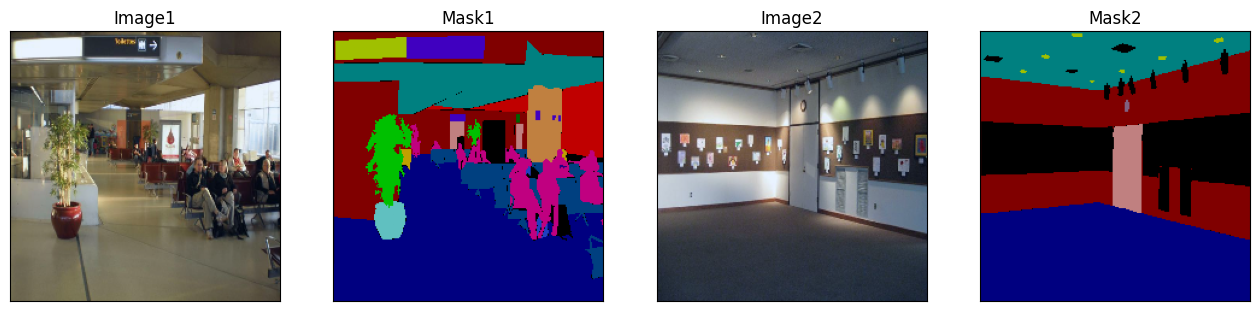

In [8]:
# idx1, idx2 = np.random.randint(1,500), np.random.randint(1,500)
idx1, idx2 = 1, 2
print(idx1,idx2)
img, mask = VOC_dataset[idx1]
img2, mask2 = VOC_dataset[idx2]
print("Img:", img.shape)
print("Mask:", mask.shape)
print("Max Value Img:",img.max())
print("Max Value Mask: {} | Unique Value Mask: {}".format(mask.max(), mask.unique()))
print(mask[:20,60:80])

# visualize(
#     image1=img.permute(1,2,0), 
#     mask1=mask.squeeze(),
#     image2 = img2.permute(1,2,0),
#     mask2 = mask2.squeeze(),
# )

visualize(
    image1=img.permute(1,2,0), 
    mask1=mask_vis(mask),
    image2 = img2.permute(1,2,0),
    mask2 = mask_vis(mask2),
)

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [10]:
# transform_size = 257
#Define trainform to images
def img_transform(trainsize= 224):
    train_transform = A.Compose([
    A.Rotate([-10,10]),
    A.RandomScale([0.5,2]),
    A.GaussianBlur(),
    A.HorizontalFlip(),
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Resize(width=trainsize, height=trainsize),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        ToTensorV2(), 
    ])
    return train_transform, test_transform

In [11]:
import copy

#patience, min_delta, restore_best_weights, best_model, best_loss counter status
#copy.deepcopy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        """
        Call method to check if early stopping is triggered.

        Args:
        model (torch.nn.Module): The model being trained.
        val_loss (float): The validation loss of the current epoch.

        Returns:
        bool: True if early stopping should occur, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss > self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stop on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True  # Stop training
        self.status = f"{self.counter}/{self.patience}"
        return False # Continue training

In [12]:
import matplotlib.pyplot as plt

def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Test Mean IoU')
        plt.title('Training and Test Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Test Dice Score')
        plt.title('Training and Test Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

In [14]:
# Training fuction
def train(model,train_dataloader,device,optimizer, epoch, EPOCHS, num_classes, writer, train_loss_meter, criterion):
    model.train()
    train_progress= tqdm(train_dataloader, colour="cyan")
    # set up learning rate scheduler
    total_steps = len(train_dataloader) * EPOCHS
    warmup_steps = int(total_steps * 0.1)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,  # Warm-up steps
        num_training_steps=total_steps  # Total training steps
    )
    
    # print(total_steps, warmup_steps)
    
    for idx, img_mask in enumerate(train_progress):
        img = img_mask[0].float().to(device) #img - B,C,H,W
        mask = img_mask[1].long().to(device) #label - B,H,W

        y_pred = model(img)
        #Optimizer 
        optimizer.zero_grad()
        # print("img = ", y_pred.shape)

        # multi_mask = torch.zeros((mask.shape[0], num_classes ,mask.shape[1],mask.shape[2] )).to('cuda',torch.float32)
        # for c in range(1, num_classes):
        #     multi_mask[:, c - 1, :,:] = (mask == c)
        # mask = multi_mask.long()
        # print("mask = ", mask.shape)

        loss = criterion(y_pred, mask) 
        loss.backward()

        torch.nn.utils.clip_grad_value_(model.parameters(), 1)

        optimizer.step()
        scheduler.step()
        
        
        train_loss_meter.update(loss.item())
        
        # tracking the loss function
        writer.add_scalar("Train/Loss", train_loss_meter.avg, epoch*len(train_dataloader)+idx)
        
        train_progress.set_description("TRAIN| Epoch: {}/{}| Iter: {}/{} | Train Loss: {:0.4f} | lr: {}".format(
            epoch+1, EPOCHS, idx, len(train_dataloader), loss, optimizer.param_groups[0]['lr']))
        
    return train_loss_meter.avg

In [15]:
#Evaluate function
def evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion):
    model.eval()
    
    with torch.no_grad():
        for idx, img_mask in enumerate(val_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].long().to(device) #B W H

            # y_pred = model(img).logits #B, 21, H, W
            # y_pred = upsample(y_pred)

            y_pred = model(img)
            # multi_mask = torch.zeros((mask.shape[0], num_classes ,mask.shape[1],mask.shape[2] )).to('cuda',torch.float32)
            # for c in range(1, num_classes):
            #     multi_mask[:, c - 1, :,:] = (mask == c)
            # mask = multi_mask.long()
            
            loss = criterion(y_pred, mask) 
            test_loss_meter.update(loss.item()) 
            
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            y_pred = y_pred.argmax(dim=1).squeeze(dim=1)
            intersection, union, target = intersectionAndUnionGPU(y_pred.float(), mask.float(), num_classes)
            intersection, union, target = intersection.cpu().numpy(), union.cpu().numpy(), target.cpu().numpy()
            intersection_meter.update(intersection), union_meter.update(union), target_meter.update(target)
            
            if idx>35: break
            
        #compute acc, iou, dice
        accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D
        macc = np.mean(accuracy_class)
        miou = np.mean(iou_class) #mean vector 21D
        mdice = np.mean(dice_class) #mean vector 21D
        
    return macc, miou, mdice, test_loss_meter.avg

In [16]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F

import segmentation_models_pytorch as smp
import shutil
from tqdm import tqdm
# from transformers import SegformerForSemanticSegmentation, SegformerConfig

In [17]:
def main(learning_rate, batch_size, epochs, num_workers, data_path, model_save_path, tensorboard_path, num_classes, checkpoint_path):
    
    # Create model save directory if it doesn't exist
    if not os.path.isdir(model_save_path):
        os.mkdir(model_save_path)
    # Creater tensorboard directory
    if os.path.isdir(tensorboard_path):
        shutil.rmtree(tensorboard_path)
    os.mkdir(tensorboard_path)
    
    
    # Data augmentation and preprocessing for training and testing
    train_transform, test_transform = img_transform()
    
    # Create datasets and dataloaders
    # train_dataset = VOCDataset(is_train=True, transform=train_transform)
    # test_dataset = VOCDataset(is_train=False, transform=test_transform)
    train_dataset = ADE20KDataset(is_train=True, transform=train_transform)
    test_dataset = ADE20KDataset(is_train=False, transform=test_transform)
    

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    # Load model and move it to the appropriate device
    # segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
    # model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
    # in_channels = model.decode_head.classifier.in_channels
    # model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

    # # segmenter 선언
    # model = Segmenter(backbone='vit_base_patch16_384', 
    #                   num_classes=21, 
    #                   image_size=384, 
    #                   emb_dim=768,
    #                   hidden_dim=3082,
    #                   num_layers=12,
    #                   num_heads=12)
    # Deeplab 선언
    model_config = {"n_cls": num_classes,  
                    "image_size": (224, 224),
                    "patch_size": 16,
                    "decoder": {              
                         "name": "mask_transformer",
                         "n_layers":12,
                         "drop_path_rate": 0.1,
                         'dropout':0.1
                        },
                    "d_model": 768,
                    # "backbone" : "vit_base_patch16_siglip_gap_512.webli"
                    "backbone": "vit_base_patch16_224.orig_in21k_ft_in1k",
                    "n_layers": 12,
                    "n_heads": 12
                    }
                         
    model = create_segmenter(model_config)
    

    # Segformer 선언
    # segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
    # model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
    # in_channels = model.decode_head.classifier.in_channels
    # model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

    # model_save_path = "./working/trained_model/"  # 예: "path/to/model/directory"
    # checkpoint_path = os.path.join(model_save_path, "best.h5")
    # if os.path.exists(checkpoint_path):
    #     checkpoint = torch.load(checkpoint_path)
    #     model.load_state_dict(checkpoint['model_state_dict'])

    
    model.to(device)
    
    # Initialize optimizer and loss function
    # num_classes = 21
    # class_weights = [0.1] + [1.0] * (num_classes - 1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = smp.losses.DiceLoss(mode="multiclass", classes = num_classes, log_loss = False, from_logits = True, smooth=1e-8,ignore_index=0)
    
    # Best validation IoU for saving the best model
    best_predict = -1
    current_epoch = 0
                                   
    # Metrics
    train_loss_list = []
    test_loss_list = []
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    
    # Early Stop
    es = EarlyStopping(patience=14,restore_best_weights=False)
    
    # # set up learning rate scheduler
    # total_steps = len(train_dataloader) * epochs
    # warmup_steps = int(total_steps * 0.001)
    # scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold= 1e-4, min_lr=0)
    # scheduler = get_linear_schedule_with_warmup(
    #     optimizer,
    #     num_warmup_steps=warmup_steps,  # Warm-up steps
    #     num_training_steps=total_steps  # Total training steps
    # )
    # difine Tensorboard    
    # print("step = ", total_steps, warmup_steps)
    writer = SummaryWriter(tensorboard_path)
    
    
    # Training loop
    for epoch in range(current_epoch,epochs): #EPOCHS
        intersection_meter.reset()
        union_meter.reset()
        target_meter.reset()
        
        #Start training model
        train_loss = train(model,train_dataloader,device,optimizer, epoch, epochs, num_classes, writer, train_loss_meter,criterion)
        acc, miou, dice, test_loss = evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion)
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
        # write in tensorboard
        writer.add_scalar("Test/Acc", acc, epoch)
        writer.add_scalar("Test/mIOU", miou, epoch)
        writer.add_scalar("Test/Dice", dice, epoch)
        
        # update learning rate
        # scheduler.step(1-miou)
        # scheduler.step()

        #Create checkpoint
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "epoch": epoch, 
            "optimizer_state_dict": optimizer.state_dict(),
            "miou": miou
        }
        
        # Save last checkpoint
        torch.save(checkpoint, os.path.join(model_save_path, "last.h5"))
        
        # Save best checkpoint based on dice score
        if miou > best_predict:
            torch.save(checkpoint, os.path.join(model_save_path, "best.h5"))
            best_predict = miou
            
        if es(model, 1-miou):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
            
        print("VAL| Acc:{:0.4f}  | mIOU: {:0.4f} | Dice: {:0.4f} | Test Loss: {:0.4f}| EStop: {}".format(
             acc, miou, dice, test_loss, es.status))
        
    #show tracking plot
    plot_segmentation_metrics(train_loss_list, test_loss_list)

In [ ]:
if __name__ == '__main__':
    # Hyperparameters and paths
    learning_rate = 1e-5
    batch_size = 16
    epochs = 100
    num_workers = os.cpu_count()
    # num_workers = 0
    data_path = "data"
    model_save_path = "./working/trained_model"
    tensorboard_path = "./working/tensorboard"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    if not os.path.exists(tensorboard_path):
        os.makedirs(tensorboard_path)
    num_classes = 151
    # Start training
    main(learning_rate,batch_size,epochs,num_workers,data_path,model_save_path,
        tensorboard_path,num_classes,model_save_path)
    pass

model load


TRAIN| Epoch: 1/100| Iter: 1262/1263 | Train Loss: 0.4741 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [10:03<00:00,  2.09it/s]


VAL| Acc:0.0190  | mIOU: 0.0075 | Dice: 0.0133 | Test Loss: 0.3070| EStop: 0/14


TRAIN| Epoch: 2/100| Iter: 1262/1263 | Train Loss: 0.4302 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [10:18<00:00,  2.04it/s]


VAL| Acc:0.0249  | mIOU: 0.0122 | Dice: 0.0207 | Test Loss: 0.3057| EStop: 0/14


TRAIN| Epoch: 3/100| Iter: 1262/1263 | Train Loss: 0.4030 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [10:26<00:00,  2.01it/s]


VAL| Acc:0.0239  | mIOU: 0.0123 | Dice: 0.0211 | Test Loss: 0.3051| EStop: 0/14


TRAIN| Epoch: 4/100| Iter: 1262/1263 | Train Loss: 0.3251 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [10:18<00:00,  2.04it/s]


VAL| Acc:0.0311  | mIOU: 0.0158 | Dice: 0.0276 | Test Loss: 0.3048| EStop: 0/14


TRAIN| Epoch: 5/100| Iter: 1262/1263 | Train Loss: 0.3445 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:59<00:00,  2.11it/s]


VAL| Acc:0.0394  | mIOU: 0.0195 | Dice: 0.0340 | Test Loss: 0.3046| EStop: 0/14


TRAIN| Epoch: 6/100| Iter: 1262/1263 | Train Loss: 0.3717 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0316  | mIOU: 0.0180 | Dice: 0.0309 | Test Loss: 0.3045| EStop: 1/14


TRAIN| Epoch: 7/100| Iter: 1262/1263 | Train Loss: 0.3574 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0380  | mIOU: 0.0207 | Dice: 0.0356 | Test Loss: 0.3044| EStop: 0/14


TRAIN| Epoch: 8/100| Iter: 1262/1263 | Train Loss: 0.3448 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0378  | mIOU: 0.0210 | Dice: 0.0361 | Test Loss: 0.3043| EStop: 0/14


TRAIN| Epoch: 9/100| Iter: 1262/1263 | Train Loss: 0.3979 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0371  | mIOU: 0.0205 | Dice: 0.0352 | Test Loss: 0.3043| EStop: 1/14


TRAIN| Epoch: 10/100| Iter: 1262/1263 | Train Loss: 0.3452 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:38<00:00,  2.18it/s]


VAL| Acc:0.0354  | mIOU: 0.0199 | Dice: 0.0341 | Test Loss: 0.3042| EStop: 2/14


TRAIN| Epoch: 11/100| Iter: 1262/1263 | Train Loss: 0.4770 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0337  | mIOU: 0.0194 | Dice: 0.0330 | Test Loss: 0.3042| EStop: 3/14


TRAIN| Epoch: 12/100| Iter: 1262/1263 | Train Loss: 0.3849 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0358  | mIOU: 0.0189 | Dice: 0.0325 | Test Loss: 0.3042| EStop: 4/14


TRAIN| Epoch: 13/100| Iter: 1262/1263 | Train Loss: 0.3775 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0367  | mIOU: 0.0195 | Dice: 0.0336 | Test Loss: 0.3041| EStop: 5/14


TRAIN| Epoch: 14/100| Iter: 1262/1263 | Train Loss: 0.3908 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0340  | mIOU: 0.0187 | Dice: 0.0323 | Test Loss: 0.3041| EStop: 6/14


TRAIN| Epoch: 15/100| Iter: 1262/1263 | Train Loss: 0.4225 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0406  | mIOU: 0.0215 | Dice: 0.0370 | Test Loss: 0.3041| EStop: 0/14


TRAIN| Epoch: 16/100| Iter: 1262/1263 | Train Loss: 0.3507 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0387  | mIOU: 0.0207 | Dice: 0.0358 | Test Loss: 0.3041| EStop: 1/14


TRAIN| Epoch: 17/100| Iter: 1262/1263 | Train Loss: 0.4371 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0375  | mIOU: 0.0209 | Dice: 0.0355 | Test Loss: 0.3040| EStop: 2/14


TRAIN| Epoch: 18/100| Iter: 1262/1263 | Train Loss: 0.4101 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0421  | mIOU: 0.0207 | Dice: 0.0357 | Test Loss: 0.3040| EStop: 3/14


TRAIN| Epoch: 19/100| Iter: 1262/1263 | Train Loss: 0.3644 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0403  | mIOU: 0.0215 | Dice: 0.0366 | Test Loss: 0.3040| EStop: 0/14


TRAIN| Epoch: 20/100| Iter: 1262/1263 | Train Loss: 0.4301 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0404  | mIOU: 0.0210 | Dice: 0.0356 | Test Loss: 0.3040| EStop: 1/14


TRAIN| Epoch: 21/100| Iter: 1262/1263 | Train Loss: 0.3053 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0400  | mIOU: 0.0213 | Dice: 0.0365 | Test Loss: 0.3040| EStop: 2/14


TRAIN| Epoch: 22/100| Iter: 1262/1263 | Train Loss: 0.3911 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0407  | mIOU: 0.0225 | Dice: 0.0381 | Test Loss: 0.3040| EStop: 0/14


TRAIN| Epoch: 23/100| Iter: 1262/1263 | Train Loss: 0.3578 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0418  | mIOU: 0.0214 | Dice: 0.0368 | Test Loss: 0.3040| EStop: 1/14


TRAIN| Epoch: 24/100| Iter: 1262/1263 | Train Loss: 0.4038 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0406  | mIOU: 0.0215 | Dice: 0.0365 | Test Loss: 0.3040| EStop: 2/14


TRAIN| Epoch: 25/100| Iter: 1262/1263 | Train Loss: 0.3703 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0411  | mIOU: 0.0227 | Dice: 0.0381 | Test Loss: 0.3040| EStop: 0/14


TRAIN| Epoch: 26/100| Iter: 1262/1263 | Train Loss: 0.4040 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0422  | mIOU: 0.0220 | Dice: 0.0377 | Test Loss: 0.3039| EStop: 1/14


TRAIN| Epoch: 27/100| Iter: 1262/1263 | Train Loss: 0.3636 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0418  | mIOU: 0.0225 | Dice: 0.0382 | Test Loss: 0.3039| EStop: 2/14


TRAIN| Epoch: 28/100| Iter: 1262/1263 | Train Loss: 0.3783 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0424  | mIOU: 0.0224 | Dice: 0.0383 | Test Loss: 0.3039| EStop: 3/14


TRAIN| Epoch: 29/100| Iter: 1262/1263 | Train Loss: 0.4570 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0418  | mIOU: 0.0216 | Dice: 0.0366 | Test Loss: 0.3039| EStop: 4/14


TRAIN| Epoch: 30/100| Iter: 1262/1263 | Train Loss: 0.3705 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0435  | mIOU: 0.0219 | Dice: 0.0375 | Test Loss: 0.3039| EStop: 5/14


TRAIN| Epoch: 31/100| Iter: 1262/1263 | Train Loss: 0.4360 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0438  | mIOU: 0.0226 | Dice: 0.0385 | Test Loss: 0.3039| EStop: 6/14


TRAIN| Epoch: 32/100| Iter: 1262/1263 | Train Loss: 0.3249 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0432  | mIOU: 0.0219 | Dice: 0.0373 | Test Loss: 0.3039| EStop: 7/14


TRAIN| Epoch: 33/100| Iter: 1262/1263 | Train Loss: 0.4109 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0435  | mIOU: 0.0226 | Dice: 0.0383 | Test Loss: 0.3039| EStop: 8/14


TRAIN| Epoch: 34/100| Iter: 1262/1263 | Train Loss: 0.3831 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0420  | mIOU: 0.0227 | Dice: 0.0385 | Test Loss: 0.3039| EStop: 0/14


TRAIN| Epoch: 35/100| Iter: 1262/1263 | Train Loss: 0.2853 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0402  | mIOU: 0.0215 | Dice: 0.0365 | Test Loss: 0.3039| EStop: 1/14


TRAIN| Epoch: 36/100| Iter: 1262/1263 | Train Loss: 0.3173 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0426  | mIOU: 0.0241 | Dice: 0.0407 | Test Loss: 0.3039| EStop: 0/14


TRAIN| Epoch: 37/100| Iter: 1262/1263 | Train Loss: 0.3642 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0443  | mIOU: 0.0241 | Dice: 0.0408 | Test Loss: 0.3039| EStop: 1/14


TRAIN| Epoch: 38/100| Iter: 1262/1263 | Train Loss: 0.3180 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0455  | mIOU: 0.0235 | Dice: 0.0399 | Test Loss: 0.3039| EStop: 2/14


TRAIN| Epoch: 39/100| Iter: 1262/1263 | Train Loss: 0.2987 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0447  | mIOU: 0.0229 | Dice: 0.0389 | Test Loss: 0.3039| EStop: 3/14


TRAIN| Epoch: 40/100| Iter: 1262/1263 | Train Loss: 0.3116 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0448  | mIOU: 0.0241 | Dice: 0.0409 | Test Loss: 0.3039| EStop: 0/14


TRAIN| Epoch: 41/100| Iter: 1262/1263 | Train Loss: 0.3445 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0406  | mIOU: 0.0227 | Dice: 0.0382 | Test Loss: 0.3039| EStop: 1/14


TRAIN| Epoch: 42/100| Iter: 1262/1263 | Train Loss: 0.4039 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:31<00:00,  2.21it/s]


VAL| Acc:0.0462  | mIOU: 0.0237 | Dice: 0.0401 | Test Loss: 0.3039| EStop: 2/14


TRAIN| Epoch: 43/100| Iter: 1262/1263 | Train Loss: 0.4301 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0444  | mIOU: 0.0229 | Dice: 0.0388 | Test Loss: 0.3039| EStop: 3/14


TRAIN| Epoch: 44/100| Iter: 1262/1263 | Train Loss: 0.3585 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0425  | mIOU: 0.0228 | Dice: 0.0383 | Test Loss: 0.3039| EStop: 4/14


TRAIN| Epoch: 45/100| Iter: 1262/1263 | Train Loss: 0.4358 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:33<00:00,  2.20it/s]


VAL| Acc:0.0437  | mIOU: 0.0230 | Dice: 0.0384 | Test Loss: 0.3038| EStop: 5/14


TRAIN| Epoch: 46/100| Iter: 1262/1263 | Train Loss: 0.3776 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.21it/s]


VAL| Acc:0.0433  | mIOU: 0.0220 | Dice: 0.0374 | Test Loss: 0.3038| EStop: 6/14


TRAIN| Epoch: 47/100| Iter: 1262/1263 | Train Loss: 0.4364 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:34<00:00,  2.20it/s]


VAL| Acc:0.0431  | mIOU: 0.0227 | Dice: 0.0381 | Test Loss: 0.3038| EStop: 7/14


TRAIN| Epoch: 48/100| Iter: 1262/1263 | Train Loss: 0.3769 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:32<00:00,  2.20it/s]


VAL| Acc:0.0437  | mIOU: 0.0226 | Dice: 0.0383 | Test Loss: 0.3038| EStop: 8/14


TRAIN| Epoch: 49/100| Iter: 1262/1263 | Train Loss: 0.3780 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:34<00:00,  2.20it/s]


VAL| Acc:0.0463  | mIOU: 0.0236 | Dice: 0.0399 | Test Loss: 0.3038| EStop: 9/14


TRAIN| Epoch: 50/100| Iter: 1262/1263 | Train Loss: 0.3574 | lr: 1.0000000000000002e-06: 100%|██████████| 1263/1263 [09:37<00:00,  2.19it/s]


VAL| Acc:0.0468  | mIOU: 0.0234 | Dice: 0.0397 | Test Loss: 0.3038| EStop: 10/14


TRAIN| Epoch: 51/100| Iter: 836/1263 | Train Loss: 0.3641 | lr: 6.627078384798099e-07:  66%|██████▋   | 837/1263 [06:19<03:31,  2.01it/s] 

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
def pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    model = model

    # Load the updated state_dict into the model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    # Load validation dataset
    image_dataset = VOCDataset(is_train=False, transform=test_transform)

    images, orig_masks, pred_masks = [], [], []
    ids = []
    # Assigned Indexs to Show
    if assigned_ids:
        ids = assigned_ids
    else:
        ids = [np.random.randint(len(image_dataset)) for _ in range(num_imgs)]
    print("indexs:", ids)
    with torch.no_grad():
        for i in range(num_imgs) :
            ori_img, mask = image_dataset[ids[i]]
            img = ori_img
            img = img.to(device).float().unsqueeze(0)
            y_pred = model(img)
            # if i==1:
            #     print('y_shape = ',y_pred.shape)
            #     print(y_pred)
            y_pred = y_pred.argmax(dim=1).squeeze(0).cpu().numpy()
            # if i==1:
            #     print(y_pred)
            #     print('arg shape = ',y_pred.shape)
            mask = mask.cpu().numpy()
            
            # Colorize masks
            color_pred_mask = np.zeros((*y_pred.shape, 3))
            color_mask = np.zeros((*mask.shape, 3))
            
            for idx, color in enumerate(VOC_COLORMAP):
                color_pred_mask[y_pred==idx] =color
                color_mask[mask==idx] = color
            
            orig_masks.append(color_mask)
            pred_masks.append(color_pred_mask)
            images.append(unorm(ori_img).permute(1, 2, 0))

    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)

    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()

In [ ]:
# Define the transformation to be applied to the test images
_, test_transform = img_transform()

#Define model
# segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
# model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
model_config = {"n_cls": 21,  
                    "image_size": (224, 224),
                    "patch_size": 16,
                    "decoder": {              
                         "name": "mask_transformer",
                         "n_layers":12,
                         "drop_path_rate": 0.2,
                         'dropout':0.1
                        },
                    "d_model": 768,
                    "backbone": "vit_base_patch16_224.orig_in21k_ft_in1k",
                    "n_layers": 12,
                    "n_heads": 12
                    }
model = create_segmenter(model_config)
# in_channels = model.decode_head.classifier.in_channels
# model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

#Note: You must train the model before using this param
model_pth = "./working/trained_model/best.h5"
device = "cuda" if torch.cuda.is_available() else "cpu" 
num_classes=  151
num_imgs = 10

In [ ]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None)

In [ ]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [1231, 772, 48, 368, 1144, 1443, 700, 610, 511, 753])

In [ ]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [58, 89, 25, 32, 4, 64, 88, 85, 28, 38])